In [22]:
import numpy as np
import pandas as pd
import main
las_data = pd.read_csv(main.csv_las_out_full_path, delimiter=';')
las_data.head()

,well_name,STRT,STOP,DEPT,aps,rp,kp,kgl,kpr,kvo,kng,lit,satur,UWI
0,224st4,2729.2,2929.4,2729.2,0.22,8.4,0.095,0.329,0.1,1.0,0.0,0.0,0.0,314_103ST2
1,224st4,2729.2,2929.4,2729.3,0.22,8.4,0.095,0.329,0.1,1.0,0.0,0.0,0.0,314_103ST2
2,224st4,2729.2,2929.4,2729.4,0.22,8.4,0.095,0.329,0.1,1.0,0.0,0.0,0.0,314_103ST2
3,224st4,2729.2,2929.4,2729.5,0.22,8.4,0.095,0.329,0.1,1.0,0.0,0.0,0.0,314_103ST2
4,224st4,2729.2,2929.4,2729.6,0.22,8.4,0.095,0.329,0.1,1.0,0.0,0.0,0.0,314_103ST2


In [23]:
del las_data['STRT']
del las_data['STOP']
del las_data['rp']
del las_data['kgl']
del las_data['kpr']
del las_data['kvo']
del las_data['kng']
del las_data['lit']
del las_data['satur']
del las_data['kp']
las_data.head()

,well_name,DEPT,aps,UWI
0,224st4,2729.2,0.22,314_103ST2
1,224st4,2729.3,0.22,314_103ST2
2,224st4,2729.4,0.22,314_103ST2
3,224st4,2729.5,0.22,314_103ST2
4,224st4,2729.6,0.22,314_103ST2


In [24]:
las_data.replace('314_', '', regex=True, inplace=True)
#del las_data['well_name']
las_data = las_data.rename(columns={'well_name': 'WELL_NAME'})
las_data = las_data.rename(columns={'UWI': 'WELL_NAME_UWI'})
las_data = las_data.rename(columns={'aps': 'APS'})
las_data = las_data.rename(columns={'DEPT': 'DEPTH'})
las_data.head(n=2)

,WELL_NAME,DEPTH,APS,WELL_NAME_UWI
0,224st4,2729.2,0.22,103ST2
1,224st4,2729.3,0.22,103ST2


In [25]:
real_top = pd.read_csv('real_data_test\\top_df.csv', delimiter=';')
real_top = real_top.rename(columns={'WELL_NAME': 'WELL_NAME_UWI'})
del real_top['X']
del real_top['Y']
real_top.head(n=2)

,WELL_NAME_UWI,DEPTH_TOP
0,100,2548.81
1,101,2556.23


In [26]:
real_bottom = pd.read_csv('real_data_test\\bottom_df.csv', delimiter=';')
real_bottom = real_bottom.rename(columns={'WELL_NAME': 'WELL_NAME_UWI'})
del real_bottom['X']
del real_bottom['Y']
real_bottom.head(n=2)

,WELL_NAME_UWI,DEPTH_BOTTOM
0,100,2564.81
1,101,2571.71


In [27]:
# данные от организаторов
water_content_data = pd.read_csv(main.data_dir + "\\water_content.csv", delimiter=';')
water_content_data = water_content_data.rename(columns={'Скважина': main.keys_dict[main.kid_well]})
water_content_data = water_content_data.rename(columns={' Начальная обводненность ': 'WC'})
water_content_data = water_content_data.rename(columns={'Дата запуска': 'date_start'})
del water_content_data['date_start']
water_content_data = water_content_data.rename(columns={'well_name': 'WELL_NAME'})
water_content_data.head(n=5)

,WELL_NAME,WC
0,380,0.49
1,379,0.30
2,370,0.13
3,417,0.08
4,389,0.22


In [28]:
# данные посчитанные на карте
wc_calc_data = pd.read_csv('fake_data\\map_wc_test_calc_res.csv', delimiter=';')
del wc_calc_data['Y']
del wc_calc_data['X']
wc_calc_data['WELL_NAME'] = wc_calc_data['WELL_NAME'].astype('str')
wc_calc_data = wc_calc_data.drop(wc_calc_data[wc_calc_data['WC'] > 1].index)
wc_calc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165 entries, 0 to 166
Data columns (total 2 columns):
WELL_NAME    165 non-null object
WC           165 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB


In [29]:
print(len(las_data['WELL_NAME'].value_counts()))
print(len(real_bottom['WELL_NAME_UWI'].value_counts()))
print(len(real_top['WELL_NAME_UWI'].value_counts()))
print(len(water_content_data['WELL_NAME'].value_counts()))
print(len(wc_calc_data['WELL_NAME'].value_counts()))

223
230
230
180
164


In [44]:
real_data = pd.merge(water_content_data, las_data, on='WELL_NAME')
#real_data = pd.merge(wc_calc_data, las_data, on='WELL_NAME')
real_data = pd.merge(real_data, real_top, on='WELL_NAME_UWI')
real_data = pd.merge(real_data, real_bottom, on='WELL_NAME_UWI') 
real_data.head()

,WELL_NAME,WC,DEPTH,APS,WELL_NAME_UWI,DEPTH_TOP,DEPTH_BOTTOM
0,380,0.49,2593.0,0.01,178,2560.32,2586.48
1,380,0.49,2593.1,0.01,178,2560.32,2586.48
2,380,0.49,2593.2,0.01,178,2560.32,2586.48
3,380,0.49,2593.3,0.01,178,2560.32,2586.48
4,380,0.49,2593.4,0.01,178,2560.32,2586.48


In [45]:
print(len(real_data['WELL_NAME'].value_counts()))
real_data.info()

166
<class 'pandas.core.frame.DataFrame'>
Int64Index: 342153 entries, 0 to 342152
Data columns (total 7 columns):
WELL_NAME        342153 non-null object
WC               342153 non-null float64
DEPTH            342153 non-null float64
APS              149958 non-null float64
WELL_NAME_UWI    342153 non-null object
DEPTH_TOP        342153 non-null float64
DEPTH_BOTTOM     340224 non-null float64
dtypes: float64(5), object(2)
memory usage: 20.9+ MB


In [46]:
real_data_na = real_data.dropna()
print(len(real_data['WELL_NAME'].value_counts()))
real_data.info()

166
<class 'pandas.core.frame.DataFrame'>
Int64Index: 342153 entries, 0 to 342152
Data columns (total 7 columns):
WELL_NAME        342153 non-null object
WC               342153 non-null float64
DEPTH            342153 non-null float64
APS              149958 non-null float64
WELL_NAME_UWI    342153 non-null object
DEPTH_TOP        342153 non-null float64
DEPTH_BOTTOM     340224 non-null float64
dtypes: float64(5), object(2)
memory usage: 20.9+ MB


In [47]:
import lasio
import re
def load_and_convert_to_interp(dev_path, well_name):
    f = open(dev_path + well_name + '.dev', 'r')
    well_num = 0
    md = []
    abs = []
    for line in f.readlines():
        if well_num > 16:
            # list = line.split(' ')
            # print(list)
            numbers = re.findall(r'[-]?[0-9]+.[0-9]+', line)
            md.append(float(numbers[0]))
            abs.append(float(numbers[3]))
        well_num = well_num +1
    f.close()
    f_spline = interpolate.interp1d(abs, md, kind = 'slinear', bounds_error=False)
    return f_spline

Загружаем переход от md в abs

In [48]:
from scipy import interpolate
dev_path = "..\\tasks\\task 6\\data\\dev\\"
well_name_list = real_data_na['WELL_NAME_UWI'].value_counts().index.tolist()
well_name = well_name_list[0]
f_spline = load_and_convert_to_interp(dev_path, well_name)
print(f_spline(0))

107.8


In [49]:
from scipy import interpolate
well_name_list = real_data_na['WELL_NAME_UWI'].value_counts().index.tolist()
x_values = []
y_values = []
count_val = 100
well_count = 0
for well_name in well_name_list:
    if well_count%20 == 0:
        print(well_count, ' of ', len(well_name_list))
    data_well =  real_data_na[real_data_na['WELL_NAME_UWI'] == well_name]
    f_spline = load_and_convert_to_interp(dev_path, well_name)
    bottom = f_spline(data_well['DEPTH_BOTTOM'].tolist()[0])
    top = f_spline(data_well['DEPTH_TOP'].tolist()[0])
    data_well_by_bound = data_well[(data_well['DEPTH'] >= top) & (data_well['DEPTH'] <= bottom)]
    x_arr = data_well_by_bound['DEPTH']
    y_arr = data_well_by_bound['APS']
    
    # print ('length of array depth', len(x_arr))
    # print(len(x_arr), len(y_arr))
    if len(x_arr) < 10:
        continue
    f_spline = interpolate.interp1d(x_arr, y_arr, kind = 'slinear')
    h_start = data_well_by_bound['DEPTH'].min()
    h_end = data_well_by_bound['DEPTH'].max()
    # print(h_start, h_end, top, bottom)
    h_step = (h_end - h_start)/count_val
    x_temp = []
    i = 0
    while(i < count_val):
        x_temp.append(float(f_spline(h_start + i * h_step)))
        i = i + 1
    x_values.append(x_temp)  
    y_values.append(data_well['WC'].tolist()[0])
    well_count = well_count + 1
print('end fill')

0  of  136
20  of  136
40  of  136
60  of  136
80  of  136
100  of  136
120  of  136
end fill


In [17]:
len(y_values)

129

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

def data_analize_func(predict_for_analize, file_name = ''):
    # подготовка данных
    data_for_analize = predict_for_analize.sort_values(by=['y_hold'])
    data_for_analize['x_axis'] = [x for x in range(len(predict_for_analize['y_hold']))]
    data_for_analize.head()
    if file_name != '':
        data_for_analize.to_csv('AllGisParams/' + file_name, index=False, sep = ';')
    
    # построение графиков
    plt.scatter(data_for_analize['x_axis'], data_for_analize['y_predict'], color = 'blue')
    plt.scatter(data_for_analize['x_axis'], data_for_analize['y_hold'], color = 'red')
    plt.show()
    
    # regression metrics
    print('MSE                      = '+ str(mean_squared_error(data_for_analize['y_hold'], 
                                                                data_for_analize['y_predict'])))
    print('MAE                      = '+ str(mean_absolute_error(data_for_analize['y_hold'], 
                                                                 data_for_analize['y_predict'])))
    print('r2_score                 = '+ str(r2_score(data_for_analize['y_hold'], 
                                                      data_for_analize['y_predict'])) + '    (best_value is 1)')
    print('explained_variance_score = '+ str(explained_variance_score(data_for_analize['y_hold'], 
                                                                      data_for_analize['y_predict'])) + '    (best_value is 1)')

In [51]:
import pickle
# Loading the saved decision tree model pickle
decision_tree_pkl_filename = 'fake_data\\decision_forest_grid_fake_data_regressor.pkl'
decision_tree_model_pkl_load = open(decision_tree_pkl_filename, 'rb')
decision_tree_model = pickle.load(decision_tree_model_pkl_load)
print("Loaded Decision tree model :: ", decision_tree_model)

Loaded Decision tree model ::  GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=17,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 10, 20, 40, 60], 'n_estimators': [1, 10, 30, 50, 100, 200, 500], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)


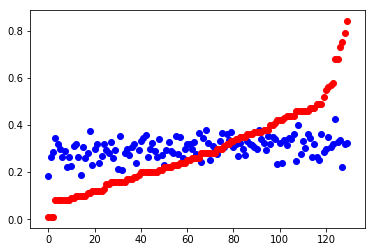

MSE                      = 0.02577812188
MAE                      = 0.128335846154
r2_score                 = 0.0918049653692    (best_value is 1)
explained_variance_score = 0.0959850003928    (best_value is 1)


In [52]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
y_pred = decision_tree_model.predict(x_values)
predict_for_analize_fake = pd.DataFrame({'y_hold':y_values, 'y_predict':y_pred})
data_analize_func(predict_for_analize_fake)


In [16]:
y_values_r = [int(10 * y_val) for y_val in y_values]

In [17]:
import pickle
# Loading the saved decision tree model pickle
decision_tree_pkl_filename = 'fake_data\\decision_forest_grid_fake_data_regressor.pkl'
decision_tree_model_pkl_load = open(decision_tree_pkl_filename, 'rb')
decision_tree_model = pickle.load(decision_tree_model_pkl_load)
print("Loaded Decision tree model :: ", decision_tree_model)
# tree_pred = decision_tree_model.predict(x_hold)
# accuracy_score(y_hold, tree_pred)

Loaded Decision tree model ::  GridSearchCV(cv=6, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=17,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 3, 5, 20, 40], 'n_estimators': [1, 5, 10, 50, 100, 200, 500], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
tree_pred = decision_tree_model.predict(x_values)
accuracy_score(y_values_r, tree_pred)

D:\libs\Anaconda\3.3\envs\aind\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.54263565891472865

In [21]:
import pickle
# Loading the saved decision tree model pickle
decision_gbt_pkl_filename = 'fake_data\\decision_gbt_grid_fake_data.pkl'
decision_gbt_model_pkl_load = open(decision_gbt_pkl_filename, 'rb')
decision_gbt_model = pickle.load(decision_gbt_model_pkl_load)
print("Loaded Decision model :: ", decision_tree_model)

Loaded Decision model ::  GridSearchCV(cv=6, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=17,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 3, 5, 20, 40], 'n_estimators': [1, 5, 10, 50, 100, 200, 500], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)


In [23]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
gbt_pred = decision_gbt_model.predict(x_values)
accuracy_score(y_values_r, gbt_pred)

0.49612403100775193

In [19]:
count = 0
for y_r, y_c in zip(y_values_r, tree_pred):
    if (abs(y_c-y_r) == 0):
        count = count + 1
    # print(y_r - y_c)
print('count = ', count, 'of ', len(y_values_r))

count =  70 of  129
